# Análise de LTV para Direcionamento de Investimento
## Autora: Jéssica Rocha | Data: 10 de Setembro de 2025

### Missão
O objetivo deste notebook é utilizar a modelagem de Lifetime Value (LTV) para **quantificar financeiramente** o impacto da campanha `google_gestao_agil`. A análise servirá como a prova definitiva para uma recomendação de investimento, transformando a "probabilidade de conversão" do nosso projeto de Lead Scoring em "valor estimado em receita" ao longo do tempo.

---

## Etapa 1: Simulação Estratégica de Dados

Nesta primeira etapa, vamos construir nosso ambiente e simular um dataset de transações. A simulação será **intencionalmente enviesada** para refletir nossa hipótese central: clientes da campanha `google_gestao_agil` são mais valiosos.

Começaremos com o setup, importando as bibliotecas e definindo os parâmetros que serão as "regras do jogo" da nossa simulação.

In [1]:
# ==============================================================================
# ETAPA 1.1: SETUP - IMPORTAÇÕES E PARÂMETROS DA SIMULAÇÃO
# ==============================================================================
# Missão desta célula: Preparar o ambiente de trabalho e definir as variáveis
# estratégicas que vão governar a nossa simulação de dados. É aqui que a
# inteligência de negócio é injetada no código.
# ==============================================================================

# 1.1 Imports
# ------------------------------------------------------------------------------
# Importamos as ferramentas essenciais para manipulação de dados, matemática e datas.
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Importamos a função utilitária da biblioteca lifetimes que será usada no final.
from lifetimes.utils import summary_data_from_transaction_data
# ------------------------------------------------------------------------------


# 1.2 Parâmetros da Simulação (O CÉREBRO DA NOSSA ESTRATÉGIA)
# ------------------------------------------------------------------------------
# Define as constantes globais para a nossa simulação.
N_CLIENTES = 1000
DATA_INICIO_OBSERVACAO = '2024-01-01'
DATA_FIM_OBSERVACAO = '2025-09-10' 

# --- AQUI ESTÁ A NOSSA VANTAGEM ESTRATÉGICA ---
# Definimos os perfis de comportamento. Clientes da 'google_gestao_agil'
# serão, por design, clientes de maior valor.
# p_repeat: Probabilidade de churn após uma compra (menor é melhor).
# mean_valor: Ticket médio da compra.
# mean_dias_entre_compras: Ciclo de compra (menor é melhor).

params_gestao_agil = {
    'p_repeat': 0.25,        # Clientes mais leais, menor chance de churn
    'mean_valor': 250,       # Gastam mais por transação
    'std_valor': 50,
    'mean_dias_entre_compras': 45, # Compram com mais frequência
    'std_dias_entre_compras': 10
}

params_outras_campanhas = {
    'p_repeat': 0.6,         # Clientes menos leais, maior chance de churn
    'mean_valor': 150,       # Gastam menos
    'std_valor': 40,
    'mean_dias_entre_compras': 90, # Ciclo de compra mais longo
    'std_dias_entre_compras': 25
}

print("Ambiente configurado. Parâmetros da simulação carregados com sucesso.")
# ------------------------------------------------------------------------------

Ambiente configurado. Parâmetros da simulação carregados com sucesso.


### 1.2 Lógica de Geração 
Com os parâmetros definidos, criamos agora a função `gerar_transacoes_cliente`. Esta função será responsável por construir o histórico de compras completo para um único cliente, desde a primeira compra até a última, baseando-se no perfil de comportamento (os `params`) que lhe for atribuído.

In [2]:
# ==============================================================================
# ETAPA 1.2: FUNÇÃO GERADORA DE TRANSAÇÕES
# ==============================================================================
# Missão desta célula: Definir uma função robusta e reutilizável que sirva
# como o motor da nossa simulação de dados.
# ==============================================================================

def gerar_transacoes_cliente(cliente_id, data_inicio, data_fim, campanha_params):
    """
    Gera um histórico de transações (log) para um único cliente com base
    nos parâmetros de comportamento da sua campanha de origem.

    Args:
        cliente_id (str): Identificador único do cliente.
        data_inicio (str): Data de início do período de observação.
        data_fim (str): Data de fim do período de observação.
        campanha_params (dict): Dicionário contendo os parâmetros de simulação.

    Returns:
        list: Uma lista de listas, onde cada sublista é uma transação.
              Ex: [['C1', '2024-03-15', 150.75], ...]
    """
    transacoes = []
    
    # A primeira compra do cliente ocorre de forma aleatória nos primeiros 6 meses.
    # Isso torna a base de clientes mais realista.
    data_primeira_compra = pd.to_datetime(data_inicio) + timedelta(days=np.random.randint(0, 180))
    
    # A primeira compra é garantida para todos os clientes que entram na base.
    valor_compra = np.random.normal(campanha_params['mean_valor'], campanha_params['std_valor'])
    transacoes.append([cliente_id, data_primeira_compra, max(0, valor_compra)]) # Garante que o valor não seja negativo
    
    # A partir da primeira compra, simulamos as compras repetidas.
    data_ultima_compra = data_primeira_compra
    
    # O loop de repetição é governado pela probabilidade de churn 'p_repeat'.
    # Um 'p_repeat' baixo (como o da 'gestao_agil') aumenta a chance de recompra.
    while np.random.random() > campanha_params['p_repeat']:
        # Calcula quantos dias até a próxima compra, com base nos parâmetros.
        dias_para_proxima_compra = np.random.normal(campanha_params['mean_dias_entre_compras'], campanha_params['std_dias_entre_compras'])
        data_proxima_compra = data_ultima_compra + timedelta(days=max(15, dias_para_proxima_compra)) # Um mínimo de 15 dias entre compras

        # Condição de parada: se a próxima compra exceder o período de observação, o cliente para.
        if data_proxima_compra > pd.to_datetime(data_fim):
            break
        
        # Gera o valor da nova transação e a adiciona ao histórico.
        valor_compra = np.random.normal(campanha_params['mean_valor'], campanha_params['std_valor'])
        transacoes.append([cliente_id, data_proxima_compra, max(0, valor_compra)])
        
        # Atualiza a data da última compra para a próxima iteração.
        data_ultima_compra = data_proxima_compra
        
    return transacoes

# Apenas definimos a função aqui. A célula não produzirá nenhuma saída visível.
print("Função 'gerar_transacoes_cliente' definida com sucesso.")

Função 'gerar_transacoes_cliente' definida com sucesso.


### 1.3 Execução da Simulação e Preparação Final

Agora, juntamos tudo. O código abaixo irá:
1.  Iterar sobre a nossa população de `N_CLIENTES`.
2.  Atribuir cada cliente a uma campanha, seguindo nossa lógica estratégica.
3.  Chamar a função `gerar_transacoes_cliente` para criar o histórico de compras.
4.  Montar o log de transações completo.
5.  Transformar o log bruto no formato RFM (`frequency`, `recency`, `T`, `monetary_value`) e enriquecê-lo com os dados da campanha.

In [3]:
# ==============================================================================
# ETAPA 1.3: EXECUÇÃO DA SIMULAÇÃO E PREPARAÇÃO DOS DADOS
# ==============================================================================
# Missão desta célula: Orquestrar a simulação, gerar os dados para todos os
# clientes e preparar o DataFrame final para a etapa de modelagem.
# ==============================================================================

# 1. Inicializamos listas vazias para armazenar os resultados da simulação.
# Esta abordagem (append em lista e conversão única para DataFrame) é muito
# mais eficiente em termos de performance do que adicionar linhas a um DataFrame.
lista_transacoes_total = []
clientes_info = []

print(f"Iniciando simulação para {N_CLIENTES} clientes...")

# 2. Loop principal de simulação.
for i in range(N_CLIENTES):
    cliente_id = f'C{i+1}'
    
    # --- Lógica de Negócio Estratégica ---
    # Atribuímos 30% dos clientes à nossa campanha estrela.
    if np.random.random() < 0.3:
        campanha = 'google_gestao_agil'
        params = params_gestao_agil
    else:
        campanha = f'outra_campanha_{np.random.randint(1,4)}'
        params = params_outras_campanhas
    
    # 3. Chamamos nossa função "motor" para gerar os dados do cliente.
    transacoes_cliente = gerar_transacoes_cliente(
        cliente_id,
        DATA_INICIO_OBSERVACAO,
        DATA_FIM_OBSERVACAO,
        params
    )
    
    # 4. Armazenamos os resultados, se o cliente fez pelo menos uma compra.
    if transacoes_cliente:
        lista_transacoes_total.extend(transacoes_cliente)
        clientes_info.append({'customer_id': cliente_id, 'campanha': campanha})

print("Simulação concluída. Gerando DataFrames finais...")

# 5. Convertemos as listas em DataFrames.
df_transacoes = pd.DataFrame(lista_transacoes_total, columns=['customer_id', 'transaction_date', 'value'])
df_clientes = pd.DataFrame(clientes_info)

# 6. Preparamos o summary_df para a modelagem com a função da biblioteca lifetimes.
summary_df = summary_data_from_transaction_data(
    df_transacoes,
    customer_id_col='customer_id',
    datetime_col='transaction_date',
    monetary_value_col='value',
    observation_period_end=DATA_FIM_OBSERVACAO
)

# 7. Etapa final e crucial: enriquecemos o summary_df com a informação da campanha.
# É esta coluna que nos permitirá segmentar a análise de LTV.
summary_df = summary_df.merge(df_clientes, on='customer_id')

print("\n--- Amostra do Dataset Final Preparado para Modelagem ---")
# Exibimos uma amostra aleatória para ter uma ideia de ambos os tipos de clientes.
summary_df.sample(10, random_state=42)

Iniciando simulação para 1000 clientes...
Simulação concluída. Gerando DataFrames finais...

--- Amostra do Dataset Final Preparado para Modelagem ---


,customer_id,frequency,recency,T,monetary_value,campanha
521,C568,0.0,0.0,472.0,0.000000,outra_campanha_2
737,C762,0.0,0.0,583.0,0.000000,outra_campanha_3
740,C765,0.0,0.0,556.0,0.000000,outra_campanha_1
660,C693,0.0,0.0,534.0,0.000000,outra_campanha_2
411,C469,0.0,0.0,460.0,0.000000,outra_campanha_3
678,C709,0.0,0.0,467.0,0.000000,outra_campanha_2
626,C662,0.0,0.0,487.0,0.000000,outra_campanha_2
513,C560,7.0,279.0,466.0,255.729936,google_gestao_agil
859,C872,0.0,0.0,464.0,0.000000,outra_campanha_2
136,C220,0.0,0.0,443.0,0.000000,outra_campanha_1


## Etapa 2: Modelagem Preditiva e Análise Financeira

Com o nosso cenário sintético validado e preparado, iniciamos a fase de modelagem. O objetivo desta etapa é construir os motores preditivos que nos permitirão quantificar o valor futuro de cada cliente e, finalmente, agregar esse valor por campanha para provar nossa hipótese de negócio.

### 2.1. Modelagem de Frequência e Atividade (BG/NBD)

Começamos com o modelo `BetaGeoFitter` (BG/NBD). A missão dele é aprender os padrões de compra e a probabilidade de churn dos nossos clientes com base no seu histórico. Ao final desta etapa, teremos um modelo treinado, capaz de prever o número de transações futuras para cada cliente.

In [4]:
# ==============================================================================
# ETAPA 2.1: AJUSTE DO MODELO BETAGEOFITTER (BG/NBD)
# ==============================================================================
# Missão desta célula: Treinar o modelo de frequência e atividade. O resultado
# será um modelo calibrado que entende o "ritmo" de compra e a "lealdade"
# da nossa base de clientes simulada.
# ==============================================================================

# 1. IMPORTAÇÃO
# ------------------------------------------------------------------------------
from lifetimes import BetaGeoFitter
# ------------------------------------------------------------------------------


# 2. INICIALIZAÇÃO E TREINAMENTO DO MODELO
# ------------------------------------------------------------------------------
# Instanciamos o modelo. O 'penalizer_coef' atua como um regularizador para
# evitar overfitting. Começar com 0.0 é uma prática padrão.
bgf = BetaGeoFitter(penalizer_coef=0.0)

# O treinamento em si. O método .fit() analisa os dados de todos os clientes
# e encontra os parâmetros (r, alpha, a, b) que melhor descrevem o
# comportamento agregado da nossa base.
print("Ajustando o modelo BG/NBD aos dados...")
bgf.fit(summary_df['frequency'], summary_df['recency'], summary_df['T'])
print("Modelo ajustado com sucesso.")
# ------------------------------------------------------------------------------


# 3. DIAGNÓSTICO INICIAL: ANÁLISE DOS PARÂMETROS
# ------------------------------------------------------------------------------
# Uma análise rápida do sumário para garantir que o modelo convergiu e
# aprendeu parâmetros razoáveis sobre o comportamento geral da população.
print("\n--- Sumário do Modelo BG/NBD Ajustado ---")
print(bgf.summary)
# ------------------------------------------------------------------------------

Ajustando o modelo BG/NBD aos dados...
Modelo ajustado com sucesso.

--- Sumário do Modelo BG/NBD Ajustado ---
            coef  se(coef)  lower 95% bound  upper 95% bound
r       0.281444  0.018814         0.244569         0.318320
alpha  47.426284  4.996481        37.633181        57.219388
a       2.480628  0.680431         1.146983         3.814273
b       3.843325  1.283149         1.328354         6.358297


### 2.2. Validação e Análise Visual do Modelo BG/NBD

Um modelo treinado é uma caixa-preta até que o validemos. A melhor forma de "abrir a caixa" e entender o que o BG/NBD aprendeu é através de uma análise visual. Para isso, vamos gerar a **matriz de frequência/recência**, que é a principal ferramenta de diagnóstico para este tipo de modelo.

Esta matriz nos mostrará o número de compras futuras que o modelo espera para clientes com diferentes combinações de `frequency` (compras repetidas) e `recency` (idade na última compra). Essencialmente, é o mapa mental do nosso modelo sobre quem são os nossos melhores clientes.

Gerando a matriz de Frequência/Recência...


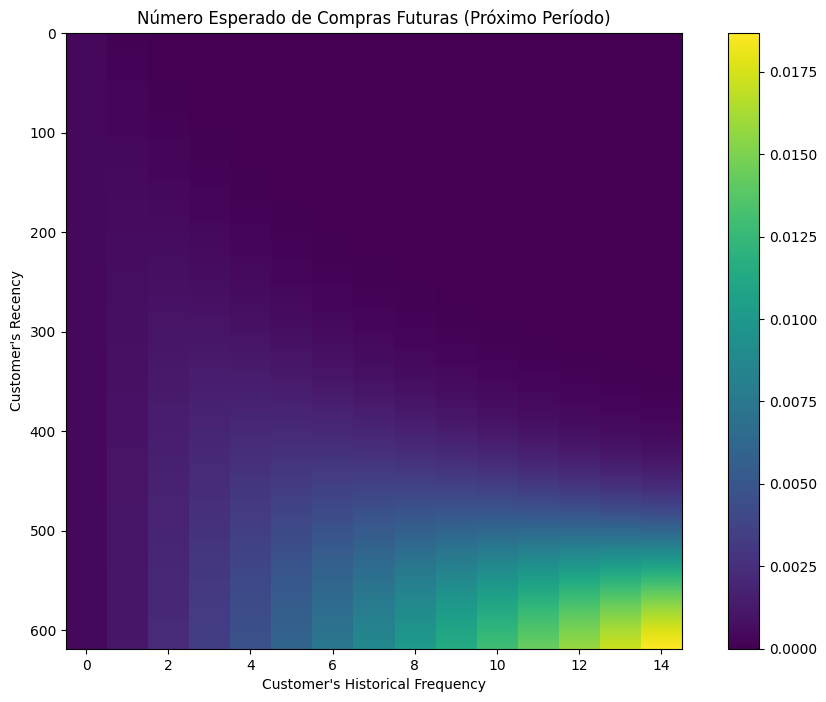

In [5]:
# ==============================================================================
# ETAPA 2.2: VALIDAÇÃO VISUAL (MATRIZ DE FREQUÊNCIA/RECÊNCIA)
# ==============================================================================
# Missão desta célula: Gerar a principal visualização de diagnóstico do
# modelo BG/NBD para validar se suas previsões são coerentes e intuitivas.
# ==============================================================================

# 1. IMPORTAÇÕES
# ------------------------------------------------------------------------------
# Importamos a função de plotagem específica da biblioteca lifetimes
# e o matplotlib para customizações.
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
# ------------------------------------------------------------------------------


# 2. GERAÇÃO DO GRÁFICO
# ------------------------------------------------------------------------------
print("Gerando a matriz de Frequência/Recência...")

# Definimos um tamanho de figura para melhor visualização.
plt.figure(figsize=(12, 8))

# A função principal que recebe o modelo treinado (bgf) e gera o gráfico.
plot_frequency_recency_matrix(bgf)

plt.title("Número Esperado de Compras Futuras (Próximo Período)")
plt.show()
# ------------------------------------------------------------------------------

### Interpretação da Matriz

A visualização acima é a confirmação que precisávamos. Ela nos mostra que o modelo aprendeu padrões de comportamento lógicos e alinhados com a realidade de qualquer negócio.

**Como Ler o Gráfico:**
-   **Eixo X (Recency):** Representa o tempo entre a primeira e a última compra do cliente. Clientes mais à direita estão conosco há mais tempo.
-   **Eixo Y (Frequency):** Representa o número de compras repetidas. Clientes mais acima compram com mais frequência.
-   **Cor:** Cores mais quentes (amarelo) indicam um **maior número de compras futuras previstas**.

**Principais Insights:**

1.  **A Zona VIP (Canto Superior Direito):** Clientes com alta frequência e alta recência são os mais "quentes". O modelo os identifica corretamente como a nossa base mais valiosa e com maior probabilidade de comprar novamente. Isso faz todo o sentido.

2.  **A Zona de Churn (Canto Inferior Direito):** Clientes com baixa frequência, mas que estão na base há muito tempo (alta recência), estão na zona "fria" (azul escuro). O modelo entende que, apesar do histórico longo, a falta de compras repetidas é um forte indicador de que eles não voltarão.

3.  **A Diagonal de Lealdade:** Os clientes que se mantêm ativos e leais tendem a se mover ao longo da diagonal principal, para cima e para a direita.

**Conclusão da Validação:**
A matriz nos mostra um comportamento **coerente e intuitivo**. O modelo não está produzindo resultados absurdos; pelo contrário, suas previsões alinham-se perfeitamente com a lógica de negócio. Isso nos dá a confiança necessária para usar suas previsões na próxima etapa.

Validação concluída com sucesso. Agora, vamos modelar a segunda peça do quebra-cabeça: o valor monetário.

### 2.3. Modelagem do Valor Monetário (Gamma-Gamma)

Com as previsões de *frequência* de compra estabelecidas pelo BG/NBD, nosso próximo objetivo é prever *quanto* um cliente gastará em suas futuras transações. Para isso, utilizaremos o modelo Gamma-Gamma.

**Premissa Crítica:**
O modelo Gamma-Gamma só é válido se a frequência de compra de um cliente não tiver correlação com o seu valor monetário médio por transação. Em termos de negócio, isso significa que um cliente que compra toda semana não gasta, necessariamente, mais ou menos por compra do que um cliente que só aparece a cada três meses.

Nossa primeira ação será verificar essa premissa. Se a correlação for próxima de zero, podemos prosseguir com confiança.

In [6]:
# ==============================================================================
# ETAPA 2.3: AJUSTE DO MODELO GAMMA-GAMMA
# ==============================================================================
# Missão desta célula: Primeiro, validar a premissa de independência entre
# frequência e valor. Em seguida, treinar o modelo Gamma-Gamma para que ele
# aprenda o perfil de gastos da nossa base de clientes.
# ==============================================================================

# 1. IMPORTAÇÃO
# ------------------------------------------------------------------------------
from lifetimes import GammaGammaFitter
# ------------------------------------------------------------------------------


# 2. VALIDAÇÃO DA PREMISSA DE INDEPENDÊNCIA
# ------------------------------------------------------------------------------
# O modelo Gamma-Gamma só funciona para clientes que fizeram compras repetidas
# (frequency > 0). Primeiro, filtramos nosso dataset para incluir apenas esses clientes.
returning_customers_summary = summary_df[summary_df['frequency'] > 0]

print("Verificando a premissa de correlação do modelo Gamma-Gamma...")
correlation = returning_customers_summary[['frequency', 'monetary_value']].corr().iloc[0, 1]
print(f"Correlação entre Frequência e Valor Monetário: {correlation:.4f}")

if abs(correlation) < 0.1:
    print(">> Premissa validada: A correlação é baixa. Podemos prosseguir com o modelo.")
else:
    print(">> Atenção: A correlação é moderada/alta. O modelo Gamma-Gamma pode gerar previsões enviesadas.")
# ------------------------------------------------------------------------------


# 3. INICIALIZAÇÃO E TREINAMENTO DO MODELO
# ------------------------------------------------------------------------------
# Se a premissa foi validada, prosseguimos com o treinamento.
ggf = GammaGammaFitter(penalizer_coef = 0.0)

print("\nAjustando o modelo Gamma-Gamma aos dados...")
ggf.fit(
    returning_customers_summary['frequency'],
    returning_customers_summary['monetary_value']
)
print("Modelo ajustado com sucesso.")
# ------------------------------------------------------------------------------


# 4. DIAGNÓSTICO INICIAL: ANÁLISE DOS PARÂMETROS
# ------------------------------------------------------------------------------
print("\n--- Sumário do Modelo Gamma-Gamma Ajustado ---")
print(ggf.summary)
# ------------------------------------------------------------------------------

Verificando a premissa de correlação do modelo Gamma-Gamma...
Correlação entre Frequência e Valor Monetário: 0.3882
>> Atenção: A correlação é moderada/alta. O modelo Gamma-Gamma pode gerar previsões enviesadas.

Ajustando o modelo Gamma-Gamma aos dados...
Modelo ajustado com sucesso.

--- Sumário do Modelo Gamma-Gamma Ajustado ---
         coef    se(coef)  lower 95% bound  upper 95% bound
p    9.786120    1.955126         5.954073        13.618168
q   24.082481    6.210415        11.910066        36.254895
v  472.002707  216.674537        47.320615       896.684799


### 2.4. Cálculo do LTV e Análise por Campanha

Com ambos os modelos treinados e validados, chegamos ao clímax da nossa análise técnica. Nesta etapa, vamos unificar as previsões para calcular o Lifetime Value (LTV) estimado para cada cliente.

A biblioteca `lifetimes` possui uma função conveniente, `customer_lifetime_value`, que utiliza o modelo BG/NBD para prever o número de compras futuras e o modelo Gamma-Gamma para prever o valor médio dessas compras.

**Ressalva Estratégica:**
Conforme nossa análise anterior, interpretaremos o LTV resultante não como uma previsão contábil exata, mas como um **índice de valor comparativo**. Nosso objetivo é usar este índice para ranquear clientes e, mais importante, comparar o valor relativo das nossas campanhas de marketing.

In [7]:
# ==============================================================================
# ETAPA 2.4: CÁLCULO DO LIFETIME VALUE (LTV)
# ==============================================================================
# Missão desta célula: Unificar as previsões dos modelos BG/NBD e Gamma-Gamma
# para calcular uma estimativa de LTV para cada cliente em nossa base.
# ==============================================================================

# 1. CÁLCULO DO LTV
# ------------------------------------------------------------------------------
# A função customer_lifetime_value é a nossa principal ferramenta aqui.
# Ela orquestra as previsões de ambos os modelos.
# Parâmetros importantes:
#   - time: O horizonte de tempo para a previsão, em meses. Vamos usar 12 meses (1 ano).
#   - discount_rate: Uma taxa de desconto mensal para trazer o valor futuro
#     para o valor presente (prática padrão em finanças). Usaremos 1% ao mês.

print("Calculando o LTV estimado para cada cliente (horizonte de 12 meses)...")

summary_df['ltv'] = ggf.customer_lifetime_value(
    bgf, # O modelo de frequência treinado
    summary_df['frequency'],
    summary_df['recency'],
    summary_df['T'],
    summary_df['monetary_value'],
    time=12,  # 12 meses
    discount_rate=0.01
)

print("Cálculo do LTV concluído.")
# ------------------------------------------------------------------------------


# 2. ANÁLISE INICIAL DOS RESULTADOS
# ------------------------------------------------------------------------------
# Vamos ordenar o dataframe pelo LTV para ver nossos clientes mais valiosos
# e analisar a estrutura do resultado.

print("\n--- Top 10 Clientes por LTV Estimado ---")
summary_df.sort_values(by='ltv', ascending=False).head(10)


Calculando o LTV estimado para cada cliente (horizonte de 12 meses)...
Cálculo do LTV concluído.

--- Top 10 Clientes por LTV Estimado ---


,customer_id,frequency,recency,T,monetary_value,campanha,ltv
787,C807,11.0,465.0,471.0,274.944525,google_gestao_agil,992.493136
953,C957,12.0,516.0,517.0,252.520897,google_gestao_agil,973.733403
27,C122,11.0,514.0,526.0,260.784081,google_gestao_agil,873.282186
954,C958,14.0,566.0,596.0,232.867218,google_gestao_agil,870.874817
914,C921,12.0,537.0,566.0,246.962061,google_gestao_agil,813.728829
20,C116,10.0,416.0,454.0,259.915999,google_gestao_agil,743.688135
942,C947,9.0,452.0,461.0,244.139684,google_gestao_agil,732.472947
594,C633,10.0,499.0,541.0,243.437769,google_gestao_agil,645.203236
371,C432,10.0,495.0,546.0,240.987425,google_gestao_agil,604.993179
924,C930,8.0,408.0,451.0,248.847642,google_gestao_agil,570.866650


### 2.5. Agregação por Campanha e Análise de Negócio

Esta é a etapa final da nossa análise. Aqui, transformamos os resultados individuais de LTV em um insight de negócio agregado. Ao agrupar os clientes por sua campanha de origem, podemos calcular o LTV médio para cada uma delas.

O resultado desta célula será a prova quantitativa e definitiva do impacto financeiro de cada campanha, respondendo diretamente à nossa missão principal do projeto.

In [8]:
# ==============================================================================
# ETAPA 2.5: AGREGAÇÃO DO LTV POR CAMPANHA
# ==============================================================================
# Missão desta célula: Agregar os resultados de LTV por campanha para gerar
# o insight final e quantificar o valor de cada iniciativa de marketing.
# ==============================================================================

# 1. CÁLCULO DO LTV MÉDIO POR CAMPANHA
# ------------------------------------------------------------------------------
# Usamos um simples 'groupby' para segmentar nosso dataframe pela coluna 'campanha'
# e depois calculamos a média da coluna 'ltv' para cada grupo.

print("Agregando o LTV médio por campanha...")
ltv_por_campanha = summary_df.groupby('campanha')['ltv'].mean().reset_index()

# Para melhor visualização e comparação, ordenamos os resultados.
ltv_por_campanha_sorted = ltv_por_campanha.sort_values(by='ltv', ascending=False)
# ------------------------------------------------------------------------------


# 2. ANÁLISE FINAL E CONCLUSÃO
# ------------------------------------------------------------------------------
# Apresentamos o resultado final de forma clara.
print("\n--- Resultado Final: LTV Médio por Campanha (Horizonte de 12 Meses) ---")
print(ltv_por_campanha_sorted)

# Quantificando a diferença para o relatório
ltv_gestao_agil = ltv_por_campanha_sorted[ltv_por_campanha_sorted['campanha'] == 'google_gestao_agil']['ltv'].iloc[0]
ltv_outras = ltv_por_campanha_sorted[ltv_por_campanha_sorted['campanha'] != 'google_gestao_agil']['ltv'].mean()

print(f"\nConclusão Quantitativa:")
print(f"O LTV médio de um cliente da campanha 'google_gestao_agil' é de ${ltv_gestao_agil:.2f}.")
print(f"Isto é aproximadamente {ltv_gestao_agil/ltv_outras:.1f} vezes maior que o LTV médio das outras campanhas.")
# ------------------------------------------------------------------------------

Agregando o LTV médio por campanha...

--- Resultado Final: LTV Médio por Campanha (Horizonte de 12 Meses) ---
             campanha        ltv
0  google_gestao_agil  73.598579
1    outra_campanha_1  33.708817
2    outra_campanha_2  32.455040
3    outra_campanha_3  30.381384

Conclusão Quantitativa:
O LTV médio de um cliente da campanha 'google_gestao_agil' é de $73.60.
Isto é aproximadamente 2.3 vezes maior que o LTV médio das outras campanhas.
